# Saving embeddings of atom types for plotting

In [1]:
import os, sys
import json
import logging
from typing import List
from tokenisation import tokenize_dataset, get_tokenizer
from pathlib import Path
from fairseq_utils2 import compute_model_output, compute_model_output_RoBERTa, load_dataset, load_model
from fairseq.data import Dictionary
from SMILES_to_SELFIES_mapping import canonize_smiles, generate_mapping, generate_mappings_for_task_SMILES_to_SELFIES
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from constants import SEED
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from collections import Counter
import seaborn as sns

from constants import (
    TASK_PATH,
    MOLNET_DIRECTORY,
    TOKENIZER_PATH
)

/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
def get_atomtype_embedding_perelem_dict(filtered_dict, colordict, entry_name_atomtype_to_embedding):
    atomtype_to_embedding_lists = [value[entry_name_atomtype_to_embedding] for value in filtered_dict.values() if entry_name_atomtype_to_embedding in value and value[entry_name_atomtype_to_embedding] is not None]
    print("len atomtype to embedding list smiles: ",len(atomtype_to_embedding_lists))
    
    # sort embeddings according to atomtype, I checked it visually and the mapping works
    embeddings_by_atomtype = {}  # Dictionary to hold lists of embeddings for each atom type
    #listembeddings = list()
    for atom_type_list in atomtype_to_embedding_lists:
        # go through single dictionary
        for tuple in atom_type_list:
           # print(f"atomtype {atom_type} embeddings {embeddings[1]}")
            if tuple[0] not in embeddings_by_atomtype:
                embeddings_by_atomtype[tuple[0]] = []
            # extend the list of embeddings for this atom type(, but ONLY by the embedding not the attached token)
            embeddings_by_atomtype[tuple[0]].append(tuple[1][0])
            #print("\ntuple01",len(tuple[1][0]),tuple[1][0])
            #print(len(embeddings[0]))
    print("embeddings c",len(embeddings_by_atomtype['c']))
    
    # sort dictionary that is mapping embeddings to atomtypes to elements so that e.g. all carbon atom types can be accessed at once in one list
    #atom_types_repeated = []
    #embeddings_list = []
    atomtype_embedding_perelem_dict = dict()
    ctr = 0
    for key in colordict.keys():
        print(f"key {key}")
        for atype in colordict[key]:
            print(atype) 
            if atype in embeddings_by_atomtype.keys():
                embsofatype = embeddings_by_atomtype[atype]
                atypes = [atype] * len(embeddings_by_atomtype[atype])
                assert len(embsofatype) == len(atypes), "Length of embeddings and atom types do not match."
                if key not in atomtype_embedding_perelem_dict:
                    atomtype_embedding_perelem_dict[key] = ([],[])
                if key in atomtype_embedding_perelem_dict:
                    atomtype_embedding_perelem_dict[key][0].extend(atypes)
                    atomtype_embedding_perelem_dict[key][1].extend(embsofatype)
    
    print(atomtype_embedding_perelem_dict.keys())
    return atomtype_embedding_perelem_dict

def colorstoatomtypesbyelement(atomtoelems_dict):
    """Generating a dictionary of colors given a dictionary that maps atomtypes to elements

    Args:
        atomtoelems_dict (_dict_): Dictionary that maps atom types to elements

    Returns:
        _dict,: Dictionary that maps atom types to colors
    """
    # https://sashamaps.net/docs/resources/20-colors/ #95% accessible only, subject to change, no white
    sash = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4',
                   '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#000000']
    #viridis
    viridis = plt.cm.get_cmap('viridis', 8)  # Get the Viridis colormap
    viridis_colors = [mcolors.to_hex(viridis(i)) for i in range(8)]  # Convert to hex 
    # tol colorscale https://personal.sron.nl/~pault/ 
    # 10 14 15 17 18 26
    tol = ['#882e72','#1965B0', '#7bafde', '#4eb265', '#cae0ab', '#f7f056', '#f1932d', '#dc050c'] 
    
    markers = ["o", "s", "^", "v", "D", "P", "X", "*"]
    
    # create dict for colors
    colornames=['sash', 'tol', 'viridis']
    colors = [sash, tol, viridis_colors]
    colordict = dict()

    for colourname, colour in zip(colornames,colors):
        colordict[colourname]={}
        for key in atomtoelems_dict.keys():
            atypes = atomtoelems_dict[key]
            keycoldict=dict()
            for at, col in zip(atypes, colour[0:len(atypes)]):
                keycoldict[at]=col    
            colordict[colourname][key]=keycoldict 
    print(colordict.items())
    print(colordict['sash'])
    
    # create dict for markers
    markerdict = dict()
    for key in atomtoelems_dict.keys():
            atypes = atomtoelems_dict[key]
            markerdictdict=dict()
            i=0
            for at in atypes:
                markerdictdict[at]=markers[i]
                i+=1  
            markerdict[key]=markerdictdict
    print(markerdict.items())
    
    
    
    # now instead for each element, get colors for a combination of atomtypes
    # p f cl o s
    #key='p f cl o s'
    #pfclos_types = atomtoelems_dict['p']+atomtoelems_dict['f']+atomtoelems_dict['cl']+atomtoelems_dict['o']+atomtoelems_dict['s']
    #keycoldicti=dict()
    #for at, col in zip(pfclos_types, colors_sash[0:len(pfclos_types)]):
    #    keycoldicti[at]=col
    #colordict[key]=keycoldicti 
    # c o
    #key='c o'
    #pfclos_types = atomtoelems_dict['c']+atomtoelems_dict['o']
    #keycoldicti=dict()
    #for at, col in zip(pfclos_types, colors_sash[0:len(pfclos_types)]):
    #    keycoldicti[at]=col
    #colordict[key]=keycoldicti 
    #print(colordict.keys())
    #print(colordict.items())
    return colordict, markerdict
    

def create_elementsubsets(atomtype_set):
    """Creation of element subsets according to alphabet

    Args:
        big_set (_set_): Set of atom types
    Returns:
        _list,dict[string][list[float],list[string]]_: List of keys (elements), dictionary that contains atomtypes sorted by element
    """
    atomtype_set=sorted(atomtype_set)
    element_dict = dict()
    elements = list()
    ctr=0
    last_firstval = ''
    for atype in atomtype_set:
        if ctr==0:
            last_firstval = atype[0]
        if not atype.startswith('cl') and atype not in element_dict.items() and atype[0]==last_firstval:
            #print(elements)
            elements.append(atype)
            element_dict[last_firstval] = elements
        elif last_firstval != atype[0] and atype != 'cl' and atype != 'br':
            element_dict[last_firstval] = elements
            elements = list()
            elements.append(atype)
            last_firstval = atype[0]
        ctr+=1
    element_dict['cl']=['cl']
    element_dict['br']=['br']
    return element_dict

def map_selfies_embeddings_to_smiles(embeds_selfies, smiles_to_selfies_mapping, dikt):
    """Map  clean SELFIES embeddings to their corresponding SMILES and atomtypes
    Args:
        embeds_selfies (_list_): List of lists of SELFIES embeddings
        smiles_to_selfies_mapping (_dict_): Dictionary that maps SMILES to SELFIES and SELFIES tokens to SMILES tokens (mappings[smiles]['selfiesstr_tok_map'] = (selfies_str,tokenised_selfies,mapping))
        dikt (_dict_): Dictionary of atom mappings etc
    Returns:
        adds SELFIES embeddings to atomtype mappings to dikt
    """
    # get embeddings for SELFIES that have a mapping to SMILES and map to SMILES in smiles_to_selfies_mapping
    for emb, smiles in zip(embeds_selfies[0], smiles_to_selfies_mapping.keys()):
        # Check if the mapping for the current smiles has a non-None value at index 2 for mapping of SELFIES to SMILES
        if smiles_to_selfies_mapping[smiles]['selfiesstr_tok_map'][2] is not None:
            # If so, set 'selfies_emb' to emb, otherwise set it to None
            smiles_to_selfies_mapping[smiles].setdefault("raw_selfies_emb", emb)
        else:
            smiles_to_selfies_mapping[smiles].setdefault("raw_selfies_emb", None)

    print("within", len(dikt.keys()))
    for key,val in dikt.items():
        #print("smiles:",key, val['atomtype_to_embedding'][0])
        if key in smiles_to_selfies_mapping.keys():
            # get list with positions to keep from dikt
            #if assignment failed posToKeep will be empty, then there is no need to map anything
            posToKeep = dikt[key]["posToKeep"]
            if posToKeep is not None:
               # print("selfies:", smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][0], smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][1])
                # if mapping exists
                if smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][2] is not None and smiles_to_selfies_mapping[key]['raw_selfies_emb'] is not None:
                   # print("key:",key)
                   # print("1111111111: ",smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][1])
                   # print("1111111111: ",smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][2].keys())
                    # 1 atom mappings and number of embeddings do not have to be even because branch, ring and overloaded tokens cannot be mapped to tokens in canonized SMILES
                    # 1 keep only the mebeddings that have a mapping
                    embs_with_mapping = []
                    for x, val in smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][2].items():
                        token_id = x[0]
                        #print("\ttoken:",x[1])
                        #print("\ttoken id:",x[0]) 
                        #print("\t in embedding: ",smiles_to_selfies_mapping[key]['raw_selfies_emb'][token_id][1])
                        #print()
                        #print("maps to smiles id: ",val)
                        #print()
                        assert x[1]==smiles_to_selfies_mapping[key]['raw_selfies_emb'][token_id][1], f"Token {x[1]} does not match token {smiles_to_selfies_mapping[key]['raw_selfies_emb'][token_id][1]}"
                        embs_with_mapping.append((val, smiles_to_selfies_mapping[key]['raw_selfies_emb'][token_id]))
                        #embs_with_mapping.append(smiles_to_selfies_mapping[key]['raw_selfies_emb'][token_id])
                    # 2 resort embeddings according to their position in the SMILES string
                    embs_with_mapping = sorted(embs_with_mapping, key=lambda item: item[0])
                    #print("sorted ", [key for key, _ in embs_with_mapping])
                   ## for _, value in embs_with_mapping:
                     #   print(value[1])
                    # 3 only keep embeddings with smiles id that belong to id that is in posToKeepList
                    filtered_embs = [(key, value) for key, value in embs_with_mapping if key in posToKeep]
                    # 4 assert that the length of the filtered embeddings is the same as the length of the posToKeep list
                    assert len(filtered_embs) == len(posToKeep), f"Length of filtered embeddings {len(filtered_embs)} and posToKeep list {len(posToKeep)} do not agree."
                    # 5 map the filtered embeddings to the atom types
                    atomtypes= dikt[key]['atom_types']
                    assert len(atomtypes) == len(filtered_embs), f"Length of atom types {len(atomtypes)} and filtered embeddings {len(filtered_embs)} do not agree."
                    atomtypes_to_selfies_embs = []
                    for atomtype, emb in zip(atomtypes, filtered_embs):
                        atomtypes_to_selfies_embs.append((atomtype, emb[1]))  
                        # assert letters of atomtype and token of embedding match
                        # checked visually, looks good
                        #print("----------------------------------------------------")
                        #print(f"atomtype {atomtype} emb {emb[1][1]}")
                        
                    # 6 attach this dictionary with name 'atomtype_to_clean_selfies_embedding' to the dikt
                    dikt[key].setdefault("atomtype_to_clean_selfies_embedding", atomtypes_to_selfies_embs) 
                else:
                    dikt[key].setdefault("atomtype_to_clean_selfies_embedding", None)
            else:
                dikt[key].setdefault("atomtype_to_clean_selfies_embedding", None)
        else:
            dikt[key].setdefault("atomtype_to_clean_selfies_embedding", None)    

def map_embeddings_to_atomtypes(dikt,task_SMILES):
    for SMILES in task_SMILES:
        if dikt[SMILES]["posToKeep"] is not None:
            atomtype_to_embedding = {}
            atom_types = dikt[SMILES]['atom_types']
            embeddings = dikt[SMILES]['clean_embedding']
            type_to_emb_tuples_list = list()
            for atom_type, embedding in zip(atom_types, embeddings):
                type_to_emb_tuples_list.append((atom_type, embedding))
                #atomtype_to_embedding.setdefault(atom_type, []).append(embedding)
                #type_to_emb_dict[atom_type] = embedding
                # assert to check whether atom type is the same as the first letter of the embedding
                assert(atom_type.lower() if atom_type.lower() =='cl' or atom_type.lower() =='br' else atom_type[0].lower()==(embedding[1][1].lower() if embedding[1].startswith("[") else embedding[1]).lower()), f"Atom assignment failed: {atom_type} != {embedding[1]}"
            dikt[SMILES]["atomtype_to_embedding"] = type_to_emb_tuples_list
        else:
            dikt[SMILES]["atomtype_to_embedding"]= (None,None)
    logging.info("Embeddings mapped to atom types, all checks passed")

def get_clean_embeds(embeds, dikt, creation_assignment_fails, task_SMILES):
    """Clean embeddings of embeddings that encode for digits, hydrogens, or structural tokens

    Args:
        embeds (_List[List[float]_): Embeddings of a SMILES
        failedSmiPos (_list_): Positions of SMILES in list where no file and/or assignment could be generated
        posToKeep_list (_list_): List of positions in a SMILES according to tokens that need to be kept (not digits, hydrogens, or structural tokens)

    Returns:
        _list[float]_: Embeddings that do not encode hydrogens, digits, or structural tokens, but only atoms
    """
    # some sanity checks on embeddings per SMILES
    assert (len(dikt.keys())) == (len(
        embeds[0])), f"Number of SMILES and embeddings do not agree. Number of SMILES: {len(dikt.keys())} of which {creation_assignment_fails} failures and Number of embeddings: {len(embeds[0])}"
    print(f"Number of SMILES: {len(dikt.keys())} with {creation_assignment_fails} failures and Number of embeddings: {len(embeds[0])}")
    
    none_embeddings = sum([1 for emb in embeds[0] if emb is None])
    print("Sum of NONE embeddings:",none_embeddings)
    
    none_sth =0
    #only keep embeddings for SMILES where atoms could be assigned to types
    embeds_clean = list()
    for smi, emb in zip(task_SMILES, embeds[0]):
        posToKeep = dikt[smi]["posToKeep"]
        # new: embeddings can be none too
        if posToKeep is not None and emb is not None:
            embeds_clean.append(emb)
            dikt[smi]["orig_embedding"]=emb
        else:
            dikt[smi]["orig_embedding"]=None
            none_sth+=1
    
    logging.info(
        f"Length embeddings before removal: {len(embeds[0])}, after removal where atom assignment failed or embedding is None: {len(embeds_clean)}")
    creation_assignment_fails_AND_none_embeddings =creation_assignment_fails+none_embeddings
    numberdel_embs = (len(embeds[0])-len(embeds_clean))
    assert none_sth == (len(
        embeds[0])-len(embeds_clean)), f"Assignment fails ({creation_assignment_fails}) plus none embeddings {none_embeddings} (leads to: {none_sth}) and number of deleted embeddings do not agree ({numberdel_embs})."

    embeds_cleaner = []
    #assert len(embeds_clean) == (len([item for item in posToKeep_list if item is not None])
     #                            ), f"Not the same amount of embeddings as assigned SMILES. {len(embeds_clean)} embeddings vs. {len([item for item in posToKeep_list if item is not None])} SMILES with positions"
    # only keep embeddings that belong to atoms
    for SMILES in task_SMILES:
        poslist = dikt[SMILES]["posToKeep"]
        emb_clean = dikt[SMILES]["orig_embedding"]

        if poslist is not None and emb_clean is not None:
            newembsforsmi = []
            newembsforsmi = [emb_clean[pos] for pos in poslist]
            embeds_cleaner.append(newembsforsmi)
            dikt[SMILES]["clean_embedding"]=newembsforsmi  
        else:
            # if original embeddings is None, make clean embedding None too
            dikt[SMILES]["clean_embedding"]=None   
            # also set posToKeep to None
            dikt[SMILES]["posToKeep"]=None

    # sanity check that length of embeddings to keep is the same as length of embeddings to keep
    posToKeep_list = [value["posToKeep"] for value in dikt.values() if value["posToKeep"] is not None]
    # sanity check that the lengths agree
    for smiemb, pos_list in zip(embeds_cleaner, posToKeep_list):
        assert len(smiemb) == len(
            pos_list), "Final selected embeddings for assigned atoms do not have same length as list of assigned atoms."
        #print(len(smiemb), pos_list)
        
    # sanity check that length of assigned atoms map to length of clean embeddings
    for SMILES in task_SMILES:
        smi_clean=dikt[SMILES]["smi_clean"]
        emb_clean = dikt[SMILES]["clean_embedding"]
        if dikt[SMILES]["posToKeep"] is not None and emb_clean is not None:
            assert len(smi_clean) == len(
                emb_clean), "SMILES and embeddings do not have same length."
            for sm, em in zip(smi_clean,emb_clean):
                #print(f"sm {sm} em {em[1]}")
                assert(sm==em[1]), f"Atom assignment failed: {sm} != {em[1]}"
    logging.info("Cleaning embeddings finished, all checks passed")
    return embeds_cleaner

def check_lengths(smi_toks, embeds):
    """Check that number of tokens corresponds to number of embeddings per SMILES, otherwise sth went wrong
     new: if sth went wrong turn that embedding to None and return the embeddings

    Args:
        smi_toks (_list[string]_): SMILES tokens for a SMILES
        embeds (_list[float]_): Embeddings
    """
    samenums = 0
    diffnums = 0
    smismaller = 0
    new_embs = list()
    for smi, embs in zip(smi_toks, embeds[0]):
        # only compare when both are not None)
        if embs is not None and smi is not None:
            if len(smi) == len(embs):
                samenums += 1
                new_embs.append(embs)
            else:
                print(f"smilen: {len(smi)} emblen: {len(embs)}")
                embs_signs = [emb1 for (emb0,emb1) in embs]
                print(f"smi: {smi} \nemb: {embs_signs} \nwith len diff {len(smi)-len(embs)}")
                diffnums += 1
                new_embs.append(None)
                if len(smi) < len(embs):
                    smismaller += 1
    embeds[0]=new_embs
    if diffnums == 0:
        return embeds
    else:
        print(
            f"same numbers between tokens and embeddings: {samenums} and different number betqween tokens and embeddings: {diffnums} of which smiles tokens have smaller length: {smismaller}")
        perc = (diffnums/(diffnums+samenums))*100
        print(
            "percentage of embeddings not correct compared to smiles: {:.2f}%".format(perc))
        return embeds

def get_embeddings(task: str, specific_model_path: str, data_path: str, cuda: int, task_reps: List[str]):
    """Generate the embeddings dict of a task
    Args:
        task (str): Task to find attention of
        cuda (int): CUDA device to use
    Returns:
        Tuple[List[List[float]], np.ndarray]: attention, labels
    """
    #task_SMILES, task_labels = load_molnet_test_set(task)

    #data_path = "/data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers"
    model = load_model(specific_model_path, data_path, cuda)
    #print("model loaded")
    model.zero_grad()
    data_path = data_path / "input0" / "test"
    # True for classification, false for regression
    dataset = load_dataset(data_path, True)
    source_dictionary = Dictionary.load(str(data_path.parent / "dict.txt"))

    assert len(task_reps) == len(
        dataset
    ), f"Real and filtered dataset {task} do not have same length: len(task_reps): {len(task_reps)} vs. len(dataset):{len(dataset)} ."
    

    #text = [canonize_smile(smile) for smile in task_SMILES]
    text = [rep for rep in task_reps]
    embeds= []
    tokenizer = None
    if "bart" in str(specific_model_path):
        embeds.append(
            compute_model_output(
                dataset,
                model,
                text, #this is very important to be in same order as task_SMILES which it is
                source_dictionary,
                False,
                False,
                True,  # true for embeddings
                True,  # true for eos_embeddings
                tokenizer,
            )[2]
        )
    if "roberta" in str(specific_model_path):
        embeds.append(
            compute_model_output_RoBERTa(
                dataset,
                model,
                text,
                source_dictionary,
                False,
                False,
                True,  # true for embeddings
                True,  # true for eos_embeddings
                tokenizer,
            )[2]
        )
   # print("attention encodings",len(attention_encodings[0]))
   # print(len(attention_encodings))
    #output = list(zip(*embeds))
    #labels = np.array(task_labels).transpose()[0]
    # print("labels",labels)
    # print(len(labels))
    return embeds

def get_embeddings_from_model(task, traintype, model, rep, reps, listoftokenisedreps):
    # ----------------------specific model paths for Delaney for BART and RoBERTa-------------------------
    finetuned_TASK_MODEL_PATH = Path("/data2/jgut/SoS_models")
    pretrained_TASK_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models")
    # path to finetuned models
    subfolder=""
    if rep=="smiles":
        #subfolder = "smiles_atom_isomers"
        subfolder = "smiles_atom_standard"
    elif rep=="selfies":
        #subfolder="selfies_atom_isomers"
        subfolder="selfies_atom_standard"
        
    if traintype=="finetuned":
        if model=="BART":
            # path for BART  
            specific_model_path = (
            finetuned_TASK_MODEL_PATH
            / task
            / f"{subfolder}_bart"
            / "1e-05_0.2_seed_0" 
            / "checkpoint_best.pt"
            )
        else:
            if rep=='selfies':
                #path for RoBERTa
                specific_model_path = (
                    finetuned_TASK_MODEL_PATH
                    / task
                    / f"{subfolder}_roberta"
                    / "5e-06_0.2_seed_0" 
                    / "checkpoint_best.pt"
                )
            else:
                #path for RoBERTa
                specific_model_path = (
                    finetuned_TASK_MODEL_PATH
                    / task
                    / f"{subfolder}_roberta"
                    / "1e-05_0.2_seed_0" 
                    / "checkpoint_best.pt"
                )
    # ----------------------specific model paths for pretrained models of BART and RoBERTa-------------------------
    elif traintype=="pretrained":
        if model=="BART":
            # path for BART   
            specific_model_path = (
                pretrained_TASK_MODEL_PATH
                / f"{subfolder}_bart"
                / "checkpoint_last.pt"
            ) 
        else:
            #path for RoBERTa
            specific_model_path = (
            pretrained_TASK_MODEL_PATH
            / f"{subfolder}_roberta"
            / "checkpoint_last.pt"
            )
    print("specific model path: ",specific_model_path)
    data_path = TASK_PATH / task / f"{subfolder}"
    
    embeds = []
    embeds = get_embeddings(task, specific_model_path, data_path, False, reps) #works for BART model with newest version of fairseq on github, see fairseq_git.yaml file
    checked_embeds = check_lengths(listoftokenisedreps, embeds) #, "Length of SMILES_tokens and embeddings do not agree."
    print("got the embeddings")
    return checked_embeds


def get_tokenized_SMILES(task_SMILES: List[str]):
    """Tokenize SMILES string

    Args:
        input_list of strings (str): List of SMILES input string

    Returns:
        dict: dictionary that links canonize SMILES string
    """

    tokenizer = get_tokenizer(TOKENIZER_PATH)
    print(f"tokenizer {tokenizer}")
    smi_toks = tokenize_dataset(tokenizer, task_SMILES, False)
    smi_toks = [smi_tok.split() for smi_tok in smi_toks]
    print(f"SMILES tokens: {smi_toks[0]}")
    smiles_dict = dict(zip(task_SMILES,smi_toks))
    return smiles_dict

def load_dictsandinfo_from_jsonfolder(input_folder):
    """
    Load atom assignments and info on failed assignments from folder that contains dictionaries on antechamber atom assignments and info files on failed assignments
    :param input_folder: folder that contains atom assignments and info on failed assignments
    :return: dict of tasks with dictionary with atom assignments, total number of failed assignments, list of failed SMILES and positions that failed, list of positions that should be kept
    """
    task_dikt = {}
    task_totalfails = {}
    for file in os.listdir(input_folder):
        if file.endswith(".json"):
            if file.startswith("dikt"):
                task = file.split("_")[1].split(".")[0]
                if task=="bace":
                    task = "bace classification"
                with open(os.path.join(input_folder, file), 'r') as f:
                    data = json.load(f)
                    task_dikt[task] = data
                    #totalfails += data['totalfails']
                    #failedSmiPos.extend(data['failedSmiPos'])
                    #posToKeep_list.extend(data['posToKeep'])
            elif file.startswith("assignment_info"):
                task=file.split(".")[0].split("_")[2]
                if task=="bace":
                    task = "bace classification"
                with open(os.path.join(input_folder, file), 'r') as f:
                    data = json.load(f)
                    task_totalfails[task] = data
                    #failedSmiPos.extend(data['failedSmiPos'])
                    #posToKeep_list.extend(data['posToKeep'])
                
    return task_dikt, task_totalfails    

In [3]:
def create_merged_dikt(model, traintype):
        # get atom assignments from folder that contains antechamber atom assignments and info files on failed assignments
    input_folder = "./assignment_dicts"
    task_dikt, task_totalfails = load_dictsandinfo_from_jsonfolder(input_folder)
    #currently available processed tasks 
    #task = "delaney" --> regression
    #task = "bace_classification" --> only fails
    #task="bbbp" --> classification
    #task="clearance" --> regression
    onlyworkingtasks=["delaney", "clearance", "bbbp","lipo"]
    test_tasks=["delaney"]
    

    merged_dikt = {}
    #print(f"totalfails: {totalfails} and total assigned molecules: {len(dikt.keys())}")
    for key, val in task_dikt.items():
        print("TASK: ",key)
        task=key
        if task not in onlyworkingtasks:
            continue
        #print(f"SMILES task: {key} \nwith dict_keys {val.keys()}")
        #print(task_dikt[key].keys())
        dikt=task_dikt[key]
        totalfails = task_totalfails[key]['totalfails']
        task_SMILES=dikt.keys()
        
        # have to tokenize SMILES just like previously in e.g. 2_AssignEmbedsPlot.py
        smiles_dict = get_tokenized_SMILES(task_SMILES)
        #for key2, val2 in val.items():
        #    print(f"{key2}: {val2}")
        percentagefailures = (totalfails/len(dikt.keys()))*100
        print(f"total fails for task {task}: {totalfails} out of {len(dikt.keys())} SMILES ({percentagefailures:.2f}%) ")
        #get embeddings from model
        #model = "ROBERTA"
        #model="BART"
        #traintype = "pretrained"
        #rep = "smiles"
        # task needs specifiyng for loading of finetuned model
        task = key
        ########################## Get embeddings from model for SMILES ############################################
        try:
            rep="smiles"
            print("get embeddings")
            embeds = get_embeddings_from_model(task, traintype, model, rep, smiles_dict.keys(), smiles_dict.values())
            #get rid of embeddings that encode for digits or hydrogens
            embeds_clean = get_clean_embeds(embeds, dikt, totalfails, task_SMILES)
            # within the dikt, map embeddings to atom types
            map_embeddings_to_atomtypes(dikt,task_SMILES)
            print()
            
            ## SELFIES------------------------------------------------------------------------------------------------------------------------------------------------------------

            # get SELFIES equivalent of SMILES and mapping between them
            smiles_to_selfies_mapping = generate_mappings_for_task_SMILES_to_SELFIES(task_SMILES)
            
            selfies_tokenised = []
            selfies = []
            maps_num = 0
            for key in smiles_to_selfies_mapping.keys():
                print(f"SMILES: {key} SELFIES: {smiles_to_selfies_mapping[key]}")
                selfies_tokenised.append(smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][1])
                selfies.append(smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][0])
                if smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][2] is not None:
                    maps_num +=1
                    for key2,val in smiles_to_selfies_mapping[key]['selfiesstr_tok_map'][2].items():
                        print(f"SELFIES index:{key2[0]} with token:{key2[1]}\tmaps to SMILES token at pos: {val}")
                print()
                
            print(f"list of tokenised selfies: {selfies_tokenised}")
            print(f"selfies {selfies} \nwith len() {len(selfies)}")
            print(f"mappings {maps_num}")
            
            rep="selfies"
            # traintype and model speicfied above
            embeds_selfies = get_embeddings_from_model(task, traintype, model, rep, selfies, selfies_tokenised)
            
            # map selfies embeddings to smiles in smiles_dict
            map_selfies_embeddings_to_smiles(embeds_selfies, smiles_to_selfies_mapping, dikt)
            for key, val in dikt.items():
                dikt[key]['task']=task
            
            
        except Exception as e:
            print(f"Error: {e}")
            continue
        merged_dikt.update(dikt)
        
    print(len(merged_dikt.keys()))
    print(merged_dikt.keys())
    valid_keys_count = len([key for key in merged_dikt.keys() if merged_dikt[key]['posToKeep'] is not None and merged_dikt[key]['atomtype_to_embedding'] is not None and merged_dikt[key]['atomtype_to_clean_selfies_embedding'] is not None])
    print("==============================================================================================================================================")
    print(f"Number of valid keys in final merged_dikt: {valid_keys_count}")
    return merged_dikt

In [4]:
def limit_embeddings(atomtype_dict_smiles, atomtype_dict_selfies, element, atom_type, limit):
    # Extract the atom type names and embeddings for the specific element
    smiles_atomtypes = atomtype_dict_smiles[element][0]
    smiles_embeddings = atomtype_dict_smiles[element][1]
    selfies_atomtypes = atomtype_dict_selfies[element][0]
    selfies_embeddings = atomtype_dict_selfies[element][1]
    
    # Ensure both lists have the same length
    assert len(smiles_atomtypes) == len(smiles_embeddings), "Mismatch in the number of atom types and embeddings in SMILES"
    assert len(selfies_atomtypes) == len(selfies_embeddings), "Mismatch in the number of atom types and embeddings in SELFIES"
    assert len(smiles_atomtypes) == len(selfies_atomtypes), "Mismatch in the number of atom types between SMILES and SELFIES"
    
    # Find indices of the specified atom type
    indices = [i for i, atype in enumerate(smiles_atomtypes) if atype == atom_type]
    
    # Limit the number of indices to the specified limit
    limited_indices = indices[:limit]
    
    # Create new lists to store the limited atom types and embeddings
    new_smiles_atomtypes = []
    new_smiles_embeddings = []
    new_selfies_atomtypes = []
    new_selfies_embeddings = []
    
    # Add all atom types and embeddings, limiting the specified atom type
    count = 0
    for i in range(len(smiles_atomtypes)):
        if smiles_atomtypes[i] == atom_type:
            if count < limit:
                new_smiles_atomtypes.append(smiles_atomtypes[i])
                new_smiles_embeddings.append(smiles_embeddings[i])
                new_selfies_atomtypes.append(selfies_atomtypes[i])
                new_selfies_embeddings.append(selfies_embeddings[i])
                count += 1
        else:
            new_smiles_atomtypes.append(smiles_atomtypes[i])
            new_smiles_embeddings.append(smiles_embeddings[i])
            new_selfies_atomtypes.append(selfies_atomtypes[i])
            new_selfies_embeddings.append(selfies_embeddings[i])
    
    # Update the dictionaries with the new lists by creating new tuples, tuples are immutable, so need to create anew
    atomtype_dict_smiles[element] = (new_smiles_atomtypes, new_smiles_embeddings)
    atomtype_dict_selfies[element] = (new_selfies_atomtypes, new_selfies_embeddings)
    assert len(atomtype_dict_smiles[element][0]) == len(atomtype_dict_smiles[element][1]), "Mismatch in the number of atom types and embeddings in SMILES"
    assert len(atomtype_dict_selfies[element][0]) == len(atomtype_dict_selfies[element][1]), "Mismatch in the number of atom types and embeddings in SELFIES"
    assert len(atomtype_dict_smiles[element][0]) == len(atomtype_dict_selfies[element][0]), "Mismatch in the number of atom types between SMILES and SELFIES"

In [5]:
def limit_all_atomtypes_to_threshold(limit, atomtype_embedding_perelem_dict_smiles_bart, atomtype_embedding_perelem_dict_selfies_bart, atomtype_embedding_perelem_dict_smiles_roberta, atomtype_embedding_perelem_dict_selfies_roberta):
    # limit embeddings for BART
    print("BART number embeddings for ca and c3 before limiting")
    print(f"Number of embeddings for 'ca' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_bart['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'ca' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_bart['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'c3' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_bart['c'][0] if atype == 'c3'])}")
    print(f"Number of embeddings for 'c3' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_bart['c'][0] if atype == 'c3'])}")
    limit_embeddings(atomtype_embedding_perelem_dict_smiles_bart, atomtype_embedding_perelem_dict_selfies_bart, 'c', 'ca', limit)
    # Print the lengths to verify
    limit_embeddings(atomtype_embedding_perelem_dict_smiles_bart, atomtype_embedding_perelem_dict_selfies_bart, 'c', 'c3', limit)
    print(f"Number of embeddings for 'ca' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_bart['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'ca' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_bart['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'c3' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_bart['c'][0] if atype == 'c3'])}")
    print(f"Number of embeddings for 'c3' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_bart['c'][0] if atype == 'c3'])}")

    print("RoBERTa number embeddings for ca and c3 before limiting")
    # same for RoBERTa
    print(f"Number of embeddings for 'ca' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_roberta['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'ca' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_roberta['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'c3' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_roberta['c'][0] if atype == 'c3'])}")
    print(f"Number of embeddings for 'c3' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_roberta['c'][0] if atype == 'c3'])}")
    limit_embeddings(atomtype_embedding_perelem_dict_smiles_roberta, atomtype_embedding_perelem_dict_selfies_roberta, 'c', 'ca', limit)

    limit_embeddings(atomtype_embedding_perelem_dict_smiles_roberta, atomtype_embedding_perelem_dict_selfies_roberta, 'c', 'c3', limit)
    print(f"Number of embeddings for 'ca' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_roberta['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'ca' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_roberta['c'][0] if atype == 'ca'])}")
    print(f"Number of embeddings for 'c3' in SMILES: {len([atype for atype in atomtype_embedding_perelem_dict_smiles_roberta['c'][0] if atype == 'c3'])}")
    print(f"Number of embeddings for 'c3' in SELFIES: {len([atype for atype in atomtype_embedding_perelem_dict_selfies_roberta['c'][0] if atype == 'c3'])}")

In [28]:
def plot_legend(legend_elements, save_path, alpha, color):
    cm = 1/2.54 
    fig, ax = plt.subplots(figsize=(8.3*cm, 2*cm))  # Adjust the size as needed
    ax.legend(handles=legend_elements, loc='center', fontsize=12, ncol=len(legend_elements), markerscale=2)
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(f"{save_path}_LEGEND_alpha{alpha}_col{color}.svg", format="svg", dpi=600, bbox_inches='tight')
    fig.clf()
    
def build_legend(data, markerdict, labels):
    """
    Build a legend for matplotlib plt from dict
    """
    # Count how often which label appears in the dataset
    label_counts = {label: labels.count(label) for label in set(labels)}
    legend_elements = []
    for key in data:
        if key not in labels:
            continue
        # Create label for legend that contains number of occurrences
        legend_label = f"{key} ({label_counts.get(key, 0)})"
        legend_elements.append(Line2D([0], [0], marker=markerdict[key], color='w', label=legend_label,
                                      markerfacecolor=data[key], markersize=9))
    return legend_elements

def plot_pca_with_markers_seaborn(embeddings, labels, marker_dict, colours_dict, save_path, namestring, color, alpha):
    """Performing PCA and plotting it

    Args:
        embeddings (_list[float]_): Embeddings of one element or a subgroup
        labels (_list[string]_): List of assigned atom types
        colours_dict (_dict[string][int]_): Dictionary of colors linking atomtypes to colors
        save_path (_string_): Path where to save plot
        alpha (float, optional): Level of opacity.
    """
    #inches to centimeters
    cm = 1/2.54 
    logging.info("Started plotting PCA")
    #before PCA I want to make sure not to plot atom types where less them 10 of those exist
    # filter out atom types and emebddings where less than 10 of those exist
    filtered_labels = []
    filtered_embeddings = []
    for label, emb in zip(labels, embeddings):
        if labels.count(label) > 10:
            filtered_labels.append(label)
            filtered_embeddings.append(emb)
    
    labels = filtered_labels
    embeddings = filtered_embeddings
    
    print("markerdict:",marker_dict)
    os.makedirs(save_path.parent, exist_ok=True)
    pca = PCA(n_components=2, random_state=SEED + 6541)
    pca_embeddings = pca.fit_transform(embeddings)
    logging.info(
        f"{save_path} has the explained variance of {pca.explained_variance_ratio_}"
    )
    explained_variance_percentages = [f"{var:.2%}" for var in pca.explained_variance_ratio_]  # Format as percentages
    
    # sort labels so plotting most frequent first and least frequent will be plotted on top
    label_counts = Counter(labels)
    sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)
    print("sorted labels:",sorted_labels)
    #rep = save_path.name.split('pca')[0]
    #fig, ax = plt.subplots(1, figsize=(8.3*cm, 8.3*cm)) #8.3cm is one column figure (10cm x 8.3 cm)
    
    # Create a DataFrame for Seaborn
    import pandas as pd
    data = pd.DataFrame({
        'PC1': pca_embeddings[:, 0],
        'PC2': pca_embeddings[:, 1],
        'label': labels
    })
    
    # Create a JointGrid
    g = sns.JointGrid(data=data, x='PC1', y='PC2', height=8.5*cm)
    
    print(f"colours dict: {colours_dict}")
    # Plot the scatter plot with markers
    for label in sorted_labels:
        marker = marker_dict[label]
        idx = data['label'] == label
        col = colours_dict[label]
        sns.scatterplot(data=data[idx], x='PC1', y='PC2', ax=g.ax_joint, marker=marker, color=col, alpha=alpha)
        
    # Add KDE plots on the sides for each label
    for label in sorted_labels:
        idx = data['label'] == label
        col = colours_dict[label]
        sns.kdeplot(data=data[idx], x='PC1', ax=g.ax_marg_x, color=col, alpha=alpha)
        sns.kdeplot(data=data[idx], y='PC2', ax=g.ax_marg_y, color=col, alpha=alpha)
        
    # Set labels and title
    g.ax_joint.set_xlabel(f"PC 1 ({explained_variance_percentages[0]})", fontsize=12)
    g.ax_joint.set_ylabel(f"PC 2 ({explained_variance_percentages[1]})", fontsize=12)
    #g.ax_joint.set_title(f"PCA for {rep} of element {namestring}", fontsize=12)
    
    # Customize spines
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.spines['left'].set_linewidth(2)
    g.ax_joint.spines['bottom'].set_linewidth(2)
    # Set tick parameters
    g.ax_joint.tick_params(length=8, width=1, labelsize=12)
    
    # Set major tick locators
    g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
    g.ax_joint.yaxis.set_major_locator(MultipleLocator(10))
    
    # Set aspect ratio
    g.ax_joint.set_aspect('equal', adjustable='box')
    
    # Calculate the limits for the axes
    x_min, x_max = data['PC1'].min(), data['PC1'].max()
    y_min, y_max = data['PC2'].min(), data['PC2'].max()
    axis_min = min(x_min, y_min)
    axis_max = max(x_max, y_max)
    margin = 0.08 * (axis_max - axis_min) + 0.1 # 5% margin
    
    # Set the same limits for both axes with margins
    g.ax_joint.set_xlim(axis_min - margin, axis_max + margin)
    g.ax_joint.set_ylim(axis_min - margin, axis_max + margin)
    
    legend_elements = build_legend(colours_dict, marker_dict, labels)
    plot_legend(legend_elements, save_path, alpha, color)

    plt.tight_layout()
    #plt.subplots_adjust(bottom=0.4)
     # Set ticks every 10 units
    g.savefig(f"{save_path}_withmarkers_alpha{alpha}_col{color})_sns.svg", format="svg", dpi=600, bbox_inches='tight')
    #plt.close()



def plot_umap_pca_lda(p_f_cl_list_embs, p_f_cl_list_assigs, namestring, save_path_prefix, markerdict, atomtype2color, min_dist, n_neighbors, color, alpha):
    #create paths on what to name the plots

    pathway_pca = Path(str(save_path_prefix) + f"pca_{namestring}")
    
    print("subplot func")
    plot_pca_with_markers_seaborn(p_f_cl_list_embs, p_f_cl_list_assigs, markerdict[namestring],
             atomtype2color[namestring], pathway_pca, namestring, color, alpha)


def plot_plots(atomtype_embedding_perelem_dict, markerdict, colordict, min_dist, n_neighbors, alpha, save_path_prefix, color):
    #namestring="c"
    #plot_umap_pca_lda(atomtype_embedding_perelem_dict[namestring][1], atomtype_embedding_perelem_dict[namestring][0], namestring, save_path_prefix, colordict, min_dist, n_neighbors, alpha)
    
    #namestring="p f cl o s"
    #plot_umap_pca_lda(atomtype_embedding_perelem_dict[namestring][1], atomtype_embedding_perelem_dict[namestring][0], namestring, save_path_prefix, colordict, min_dist, n_neighbors, alpha)
    
    #namestring = "c o"
    #plot_umap_pca_lda(atomtype_embedding_perelem_dict[namestring][1], atomtype_embedding_perelem_dict[namestring][0], namestring, save_path_prefix, colordict, min_dist, n_neighbors, alpha)
    
    print("Plotting................................BY ELEMENT")
    # plot all atomtypes of one element only
    for key in colordict.keys():
        print("key",key)
        if len(key)<=2 and key!='cl' and key in atomtype_embedding_perelem_dict.keys():
            print(f"#######KEY {key}\n")
            pathway_umap = Path(str(save_path_prefix) +
                                f"umap_{min_dist}_{n_neighbors}_{key}.svg")
            pathway_pca = Path(str(save_path_prefix) + f"pca_{key}.svg")
            pathway_lda = Path(str(save_path_prefix) + f"lda_{key}.svg")
            embeddings = atomtype_embedding_perelem_dict[key][1]
            assignments = atomtype_embedding_perelem_dict[key][0]
            print("ASSIGNMENTS: ", assignments)
            #atomtype2color, set_list = getcolorstoatomtype(set(assignments.copy()))

            try:
                assert len(embeddings) == (len(assignments)), "Assignments and embeddings do not have same length."
                assert len(embeddings)>10, "Not enough embeddings for plotting"
                print(f"len embeddings of key {key}: {len(embeddings)}")
                plot_umap_pca_lda(embeddings, assignments, key, save_path_prefix, markerdict, colordict, min_dist, n_neighbors, color, alpha)
                #plot_pca(embeddings, assignments, atomtype2color, pathway_pca, alpha)
                #plot_lda(embeddings, assignments, atomtype2color, pathway_lda, alpha)
                #plot_umap(embeddings, assignments, atomtype2color, pathway_umap, min_dist, n_neighbors, alpha)
            except AssertionError as e:
                print(f"Assertion error occurred for element {key}: {e}")
                continue 

def create_plotsperelem(atomtype_embedding_perelem_dict_smiles, atomtype_embedding_perelem_dict_selfies, markerdict, colordict, min_dist, n_neighbors, alpha, save_path_prefix, color, model):
    """Create plot per element and for all element subsets

    Args:
        dikt (_dict_): Dictionary of atom mappings etc
        colordict (_dict[string][dict[string],[color]]): Dictionary that maps atom types to colors
        penalty_threshold (_float_): Threshold for max penalty score
        min_dist (_float_): Number of min dist to use in UMAP
        n_neighbors (_int_): Number of neighbors to use in UMAP
        alpha (_int_): Level of opacity
        save_path_prefix (_string_): Path prefix where to save output plot
    """
    print(colordict.keys())
    #plot for SMILES
    plot_plots(atomtype_embedding_perelem_dict_smiles, markerdict, colordict, min_dist, n_neighbors, alpha, f"{save_path_prefix}{model}_smiles", color)
    # plot for SELFIES
    plot_plots(atomtype_embedding_perelem_dict_selfies, markerdict, colordict, min_dist, n_neighbors, alpha, f"{save_path_prefix}{model}_selfies", color)

In [7]:
def filter_dicts_on_parmchk_penalty_threshold(merged_dict_bart, merged_dict_roberta, penalty_threshold):
    
    #filter both dicts at the same time based on penalty threshold
    filtered_merged_dict_bart = {smiles: info for smiles, info in merged_dict_bart.items() if info['max_penalty'] is not None and info['max_penalty'] < penalty_threshold}
    filtered_merged_dict_roberta = {smiles: merged_dict_roberta[smiles] for smiles in filtered_merged_dict_bart if smiles in merged_dict_roberta}
     
    print(f"Len before filtering - bart_dict: {len(merged_dict_bart.keys())} and after threshold filtering: {len(filtered_merged_dict_bart.keys())}")
    print(f"Len before filtering - roberta_dict: {len(merged_dict_roberta.keys())} and after threshold filtering: {len(filtered_merged_dict_roberta.keys())}")
    
    # there are less SELFIES embeddings that could be mapped to the SMILES and thereby the atomtypes, so the number of embeddings is less
    # therefore filter filtered_dict further on what is available for SELFIES and also what is available for SMILES
    filtered_embs_bart_dict = {smiles: info for smiles, info in filtered_merged_dict_bart.items() if info['atomtype_to_embedding'] is not None and info['atomtype_to_clean_selfies_embedding'] is not None}
    filtered_embs_roberta_dict = {smiles: filtered_merged_dict_roberta[smiles] for smiles in filtered_embs_bart_dict if smiles in filtered_merged_dict_roberta}
    
    
    print(f"Len before filtering - bart_dict: {len(filtered_merged_dict_bart.keys())} and after embedding filtering: {len(filtered_embs_bart_dict.keys())}")
    print(f"Len before filtering - roberta_dict: {len(filtered_merged_dict_roberta.keys())} and after embedding filtering: {len(filtered_embs_roberta_dict.keys())}")
    
    
    return filtered_embs_bart_dict, filtered_embs_roberta_dict

In [8]:
def get_colorsubdict(filtered_embs_bart_dict, color):
    # create 
    unique_atomtype_set = set(chain.from_iterable(filtered_embs_bart_dict[key]['atom_types'] for key in filtered_embs_bart_dict if filtered_embs_bart_dict[key].get('atom_types') is not None))
    basic_atomtypes_to_elems_dict = {'c': ['c', 'c1', 'c2', 'c3', 'ca'], 'o': ['o', 'oh', 'os'], 'n': ['n', 'n1', 'n2', 'n3', 'n4', 'na', 'nh', 'no']}
    atomtypes_to_elems_dict = create_elementsubsets(unique_atomtype_set)
    # get colors for atomtypes by element and element groups
    colordict, markerdict = colorstoatomtypesbyelement(basic_atomtypes_to_elems_dict)
    #print(colordict['sash']['c'])
    print(markerdict)
    colorsubdict=colordict[color]
    return colorsubdict, markerdict

In [9]:
create_dicts=False
traintype="pretrained"
if create_dicts:
    
    model ="BART"
    merged_dikt_bart = create_merged_dikt(model, traintype)

    model ="roberta"
    merged_dikt_roberta = create_merged_dikt(model, traintype)

    print(merged_dikt_bart.keys())
    print(len(merged_dikt_bart.keys()))

    print(merged_dikt_roberta.keys())
    print(len(merged_dikt_roberta.keys()))

    #confirm it's the same keys please 
    for key in merged_dikt_bart.keys():
        if key not in merged_dikt_roberta.keys():
            print(f"key {key} not in roberta")
    for key,val in zip(merged_dikt_bart.keys(),merged_dikt_roberta.keys()):
        #print(key, val)
        if key!=val:
            print(f"key {key} not equal to val {val}")

    # save merged dicts
    import json
    with open('./assignment_dicts/merged_dikt_bart.json', 'w') as f:
        json.dump(merged_dikt_bart, f)
    with open('./assignment_dicts/merged_dikt_roberta.json', 'w') as f:
        json.dump(merged_dikt_roberta, f)
else:
    print("Merged dicts were already created, no need to create them again.")
    with open('./assignment_dicts/merged_dikt_bart.json', 'r') as f:
        merged_dikt_bart = json.load(f)
    with open('./assignment_dicts/merged_dikt_roberta.json', 'r') as f:
        merged_dikt_roberta = json.load(f)
        
print(len(merged_dikt_bart.keys()))
print(len(merged_dikt_roberta.keys()))

Merged dicts were already created, no need to create them again.
791
791


In [10]:
# filter on parmchk penalty threshold
penalty_threshold = 300
filtered_embs_bart_dict, filtered_merged_dict_roberta = filter_dicts_on_parmchk_penalty_threshold(merged_dikt_bart, merged_dikt_roberta, penalty_threshold)

# get colordict
color="tol"
colorsubdict, markerdict = get_colorsubdict(filtered_embs_bart_dict, color)

# get all atomtype_to_embeddings dicts
atomtype_embedding_perelem_dict_smiles_bart = get_atomtype_embedding_perelem_dict(filtered_embs_bart_dict, colorsubdict, 'atomtype_to_embedding')
atomtype_embedding_perelem_dict_selfies_bart = get_atomtype_embedding_perelem_dict(filtered_embs_bart_dict, colorsubdict, 'atomtype_to_clean_selfies_embedding')

atomtype_embedding_perelem_dict_smiles_roberta = get_atomtype_embedding_perelem_dict(filtered_merged_dict_roberta, colorsubdict, 'atomtype_to_embedding')
atomtype_embedding_perelem_dict_selfies_roberta = get_atomtype_embedding_perelem_dict(filtered_merged_dict_roberta, colorsubdict, 'atomtype_to_clean_selfies_embedding')

limit = 300
limit_all_atomtypes_to_threshold(limit, atomtype_embedding_perelem_dict_smiles_bart, atomtype_embedding_perelem_dict_selfies_bart, atomtype_embedding_perelem_dict_smiles_roberta, atomtype_embedding_perelem_dict_selfies_roberta)

Len before filtering - bart_dict: 791 and after threshold filtering: 479
Len before filtering - roberta_dict: 791 and after threshold filtering: 479
Len before filtering - bart_dict: 479 and after embedding filtering: 143
Len before filtering - roberta_dict: 479 and after embedding filtering: 143
dict_items([('sash', {'c': {'c': '#e6194B', 'c1': '#3cb44b', 'c2': '#ffe119', 'c3': '#4363d8', 'ca': '#f58231'}, 'o': {'o': '#e6194B', 'oh': '#3cb44b', 'os': '#ffe119'}, 'n': {'n': '#e6194B', 'n1': '#3cb44b', 'n2': '#ffe119', 'n3': '#4363d8', 'n4': '#f58231', 'na': '#911eb4', 'nh': '#42d4f4', 'no': '#f032e6'}}), ('tol', {'c': {'c': '#882e72', 'c1': '#1965B0', 'c2': '#7bafde', 'c3': '#4eb265', 'ca': '#cae0ab'}, 'o': {'o': '#882e72', 'oh': '#1965B0', 'os': '#7bafde'}, 'n': {'n': '#882e72', 'n1': '#1965B0', 'n2': '#7bafde', 'n3': '#4eb265', 'n4': '#cae0ab', 'na': '#f7f056', 'nh': '#f1932d', 'no': '#dc050c'}}), ('viridis', {'c': {'c': '#440154', 'c1': '#46327e', 'c2': '#365c8d', 'c3': '#277f8e', '

PLOT for model BART
dict_keys(['c', 'o', 'n'])
Plotting................................BY ELEMENT
key c
#######KEY c

ASSIGNMENTS:  ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c1', 'c1', 'c1', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c2', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 'c3', 

/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


key n
#######KEY n

ASSIGNMENTS:  ['n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n2', 'n2', 'n2', 'n2', 'n2', 'n2', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'n3', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh', 'nh']
len embeddings of key n: 110
subplot func
markerdict: {'n': 'o', 'n1': 's', 'n2': '^', 'n3': 'v', 'n4': 'D', 'na': 'P', 'nh': 'X', 'no': '*'}
sorted labels: ['na', 'n', 'n3', 'nh']
colours dict: {'n': '#882e72', 'n1': '#1965B0', 'n2': '#7bafde', 'n3': '#4eb265', 'n4': '#cae0ab', 'na': '#f7f056', 'nh': '#f1932d', 'no': '#dc05

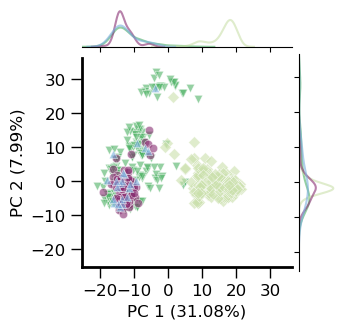

<Figure size 326.772x78.7402 with 0 Axes>

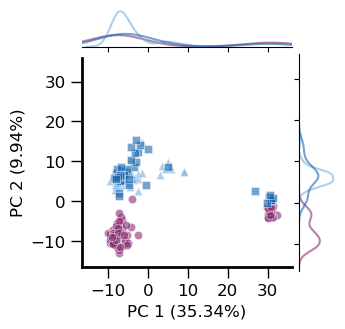

<Figure size 326.772x78.7402 with 0 Axes>

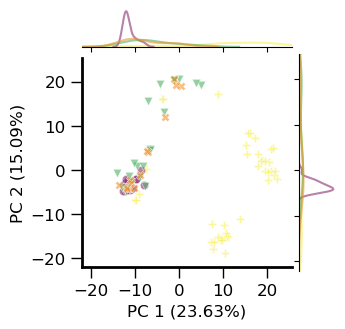

<Figure size 326.772x78.7402 with 0 Axes>

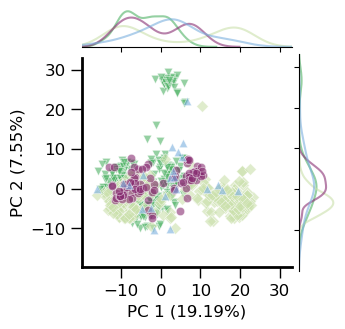

<Figure size 326.772x78.7402 with 0 Axes>

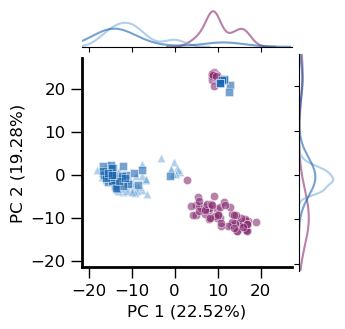

<Figure size 326.772x78.7402 with 0 Axes>

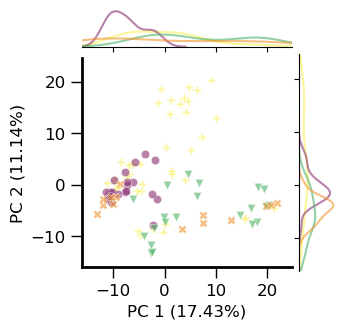

<Figure size 326.772x78.7402 with 0 Axes>

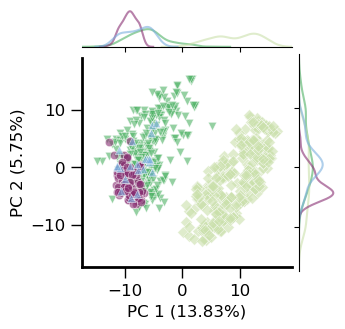

<Figure size 326.772x78.7402 with 0 Axes>

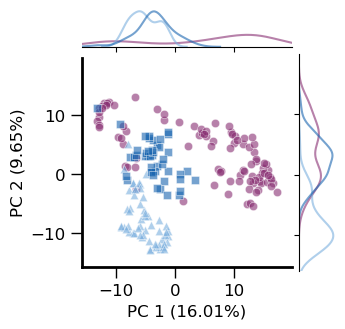

<Figure size 326.772x78.7402 with 0 Axes>

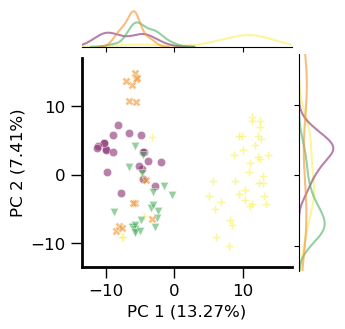

<Figure size 326.772x78.7402 with 0 Axes>

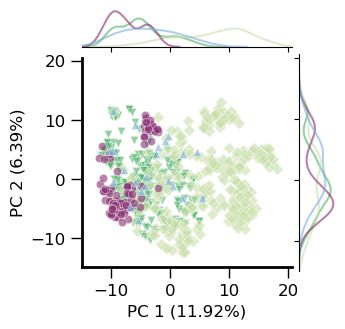

<Figure size 326.772x78.7402 with 0 Axes>

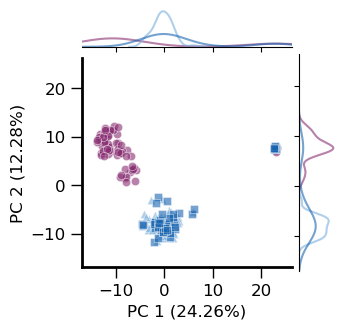

<Figure size 326.772x78.7402 with 0 Axes>

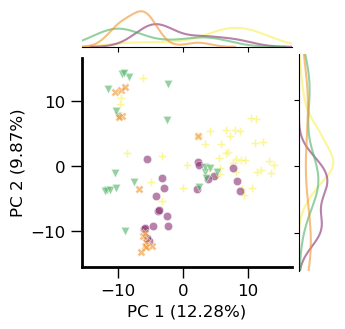

<Figure size 326.772x78.7402 with 0 Axes>

In [29]:
traintype="pretrained"
final_validkeys = len([key for key in filtered_embs_bart_dict.keys() if filtered_embs_bart_dict[key]['posToKeep'] is not None and filtered_embs_bart_dict[key]['atomtype_to_embedding'] is not None and filtered_embs_bart_dict[key]['atomtype_to_clean_selfies_embedding'] is not None])
save_path_prefix = f"./14_2_25__PaulTolColor_{traintype}_delaney_bbbp_clearance_lipo_mols{final_validkeys}_thresh{penalty_threshold}_ctypelimit{limit}/"
min_dist = 0.1
n_neighbors = 15
alpha = 0.6

model="BART"
print(f"PLOT for model {model}")
create_plotsperelem(atomtype_embedding_perelem_dict_smiles_bart, atomtype_embedding_perelem_dict_selfies_bart, markerdict, colorsubdict, min_dist, n_neighbors, alpha, save_path_prefix, color, model)

model="roberta"
print(f"PLOT for model {model}")
create_plotsperelem(atomtype_embedding_perelem_dict_smiles_roberta, atomtype_embedding_perelem_dict_selfies_roberta, markerdict, colorsubdict, min_dist, n_neighbors, alpha, save_path_prefix, color, model)